In [51]:
import numpy as np
gravitational_constant_lsb = 16384

In [52]:
# Read the csv file and print the first 5 rows
def read_csv(file_name):
    data = np.genfromtxt(file_name, delimiter=';')
    return data

In [53]:
acc_and_gyro_data = read_csv('data/acc_drop_1m_ms_3.csv')

In [54]:
print(acc_and_gyro_data[0:5])

[[54531.  -400. -2776. 14928.]
 [54555.  -164. -3040. 14760.]
 [54580.  -200. -2972. 14976.]
 [54605.  -492. -2300. 14764.]
 [54630.  -324. -2840. 14960.]]


In [55]:
acc_data_in_g = acc_and_gyro_data[:, 1:4] / gravitational_constant_lsb

In [56]:
print(acc_data_in_g[0:5])

[[-0.02441406 -0.16943359  0.91113281]
 [-0.01000977 -0.18554688  0.90087891]
 [-0.01220703 -0.18139648  0.9140625 ]
 [-0.0300293  -0.14038086  0.90112305]
 [-0.01977539 -0.17333984  0.91308594]]


In [57]:
timestamps = acc_and_gyro_data[:, 0]
timestamps = timestamps - timestamps[0]
#convert to uint32
timestamps = timestamps.astype(np.uint32)
print(timestamps[0:5])
print(timestamps[-1])

[ 0 24 49 74 99]
5982


In [58]:
def normalize(vector):
    """ Normalize a vector. """
    norm = np.linalg.norm(vector)
    if norm != 0:
        return vector / norm
    else:
        return vector

def rotation_matrix_from_vectors(vec1, vec2):
    """ Calculate the rotation matrix that aligns vec1 to vec2. """
    a, b = normalize(vec1), normalize(vec2)
    cross_product = np.cross(a, b)
    sin_angle = np.linalg.norm(cross_product)
    cos_angle = np.dot(a, b)
    
    if sin_angle == 0:
        # vec1 and vec2 are parallel (either the same or opposite)
        if cos_angle > 0:
            return np.identity(3)  # same direction
        else:
            # 180 degree rotation around any orthogonal vector
            orthogonal_vector = np.cross(a, np.array([1, 0, 0]))
            if np.linalg.norm(orthogonal_vector) == 0:  # they were collinear with x-axis
                orthogonal_vector = np.cross(a, np.array([0, 1, 0]))
            orthogonal_vector = normalize(orthogonal_vector)
            return rotation_matrix_from_vectors(a, orthogonal_vector) @ rotation_matrix_from_vectors(orthogonal_vector, -a)
    
    cross_product_matrix = np.array([
        [0, -cross_product[2], cross_product[1]],
        [cross_product[2], 0, -cross_product[0]],
        [-cross_product[1], cross_product[0], 0]
    ])
    
    rotation_matrix = np.identity(3) + cross_product_matrix + \
                      cross_product_matrix @ cross_product_matrix * ((1 - cos_angle) / (sin_angle ** 2))
    
    return rotation_matrix

In [59]:
def calibrate_axis_to_measurement(data, measurement):
    """ Calibrate the axis of the data to the first measurement. """
    return data @ rotation_matrix_from_vectors(measurement, np.array([0, 0, 1]))

In [60]:
# Calculate average of first 10 rows
avg = np.mean(acc_data_in_g[0:10], axis=0)
print(avg[0:3])

[-0.01486816 -0.17993164  0.90244141]


In [61]:
calibrated_data_in_g = calibrate_axis_to_measurement(acc_data_in_g, avg)
print(calibrated_data_in_g[0:5])

[[-0.03886031 -0.34425931  0.85990825]
 [-0.02426656 -0.35807985  0.846936  ]
 [-0.02668314 -0.35658357  0.86063937]
 [-0.04435943 -0.31380132  0.85568234]
 [-0.03424758 -0.34847942  0.86113466]]


In [62]:
# use average of first 20 rows as calibration point
calibration_point = np.mean(calibrated_data_in_g[0:20], axis=0)
print(calibration_point[0:3])
# Offset gravity
calibrated_data_in_g = calibrated_data_in_g - np.array(calibration_point)

[-0.03972889 -0.3478293   0.85664256]


In [63]:
pitch = np.arctan2(avg[0], np.sqrt(avg[1]**2 + avg[2]**2))
roll = np.arctan2(avg[1], avg[2])
print('Pitch:', pitch, 'Roll:', roll)

Pitch: -0.016156054699754164 Roll: -0.1968023969036817


In [64]:
test = np.arange(0, timestamps[-1], 10, dtype=np.uint32)
print(len(timestamps))


255


In [65]:
# plot x, y anz acceleration in time    
import matplotlib.pyplot as plt
def plot_axis_data(data, timestamps, title=''):
    plt.xticks(np.arange(0, len(data), 50, dtype=np.uint32), timestamps[::50])
    plt.xlabel('Time (ms)')
    plt.plot(data[:, 0], label='x')
    plt.plot(data[:, 1], label='y')
    plt.plot(data[:, 2], label='z')
    plt.title(title)
    plt.legend()
    plt.show()

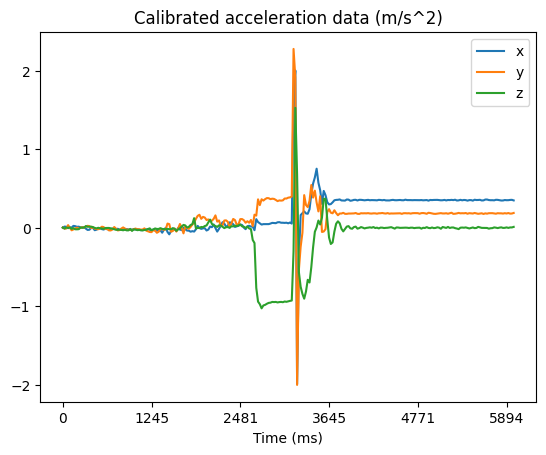

In [66]:
plot_axis_data(calibrated_data_in_g, timestamps, 'Calibrated acceleration data (m/s^2)')

In [67]:
def integrate_to_velocity(data, timestamps, initial_velocity):
    """ Integrate acceleration to velocity. """
    velocity = np.zeros(data.shape)
    velocity[0] = initial_velocity
    for i in range(1, len(data)):
        dt = (timestamps[i] - timestamps[i - 1]) / 1000
        velocity[i] = velocity[i - 1] + data[i] * dt
    return velocity

In [68]:
velocity_data = integrate_to_velocity(calibrated_data_in_g, timestamps, np.zeros(3))
print(velocity_data[0:5])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.71095861e-04 -2.46013195e-04 -2.32957350e-04]
 [ 6.97239538e-04 -4.64869832e-04 -1.33037202e-04]
 [ 5.81476080e-04  3.85829777e-04 -1.57042761e-04]
 [ 7.18508915e-04  3.69576862e-04 -4.47403883e-05]]


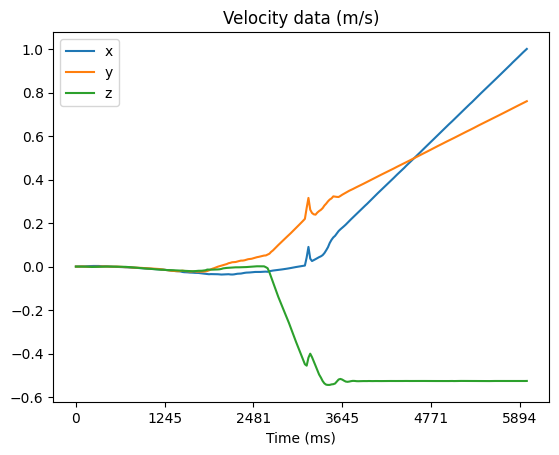

In [69]:
plot_axis_data(velocity_data, timestamps, 'Velocity data (m/s)')

In [70]:
def integrate_to_position(velocity_data, timestamps, initial_position):
    """ Integrate velocity to position. """
    position = np.zeros(velocity_data.shape)
    position[0] = initial_position
    for i in range(1, len(velocity_data)):
        dt = (timestamps[i] - timestamps[i - 1]) / 1000
        position[i] = position[i - 1] + velocity_data[i] * dt
    return position

In [71]:
position_data = integrate_to_position(velocity_data, timestamps, np.array([0, 0, 0.8]))

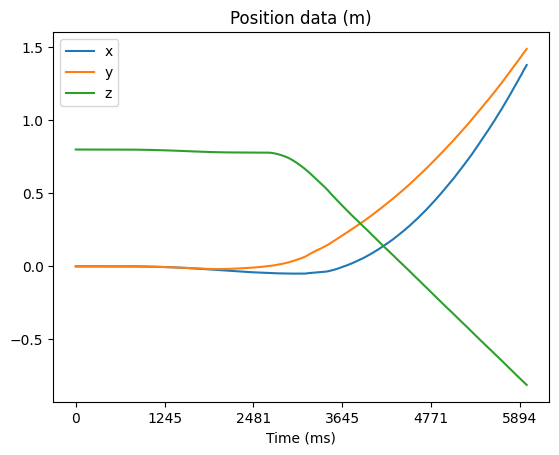

In [72]:
plot_axis_data(position_data, timestamps, 'Position data (m)')